In [46]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, AgglomerativeClustering

# dataset: 
# https://chronicdata.cdc.gov/Behavioral-Risk-Factors/Behavioral-Risk-Factor-Surveillance-System-BRFSS-P/
df = pd.read_csv('Behavioral_Risk.csv')

In [127]:
df.head()

,Locationdesc,Class,Topic,Question,Response,Break_Out,Break_Out_Category,Sample_Size,Data_value,Confidence_limit_Low,Confidence_limit_High
0,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,Yes,18-24,Age Group,172,50.0,43.6,56.4
1,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,No,18-24,Age Group,176,50.0,43.6,56.4
2,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,Yes,25-34,Age Group,302,52.2,47.4,57.0
3,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,No,25-34,Age Group,299,47.8,43.0,52.7
4,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,Yes,35-44,Age Group,385,48.5,44.3,52.8


In [48]:
# we drop columns that have more than 50% of data missing
drop_cols = ['BreakoutID', 'BreakOutCategoryID', 'ClassId', 'Data_Value_Footnote_Symbol', 
             'Data_Value_Footnote', 'DataSource', 'Data_value_unit', 'Data_value_type', 
             'Display_order', 'GeoLocation', 'Locationabbr', 'LocationID', 'QuestionID', 
             'ResponseID', 'TopicId', 'Year']

df.drop(axis=1, columns=drop_cols, inplace=True)

# fill missing values with median values
nul_cols = ['Data_value', 'Confidence_limit_Low', 'Confidence_limit_High']

for col in nul_cols:
    df[col].fillna(df[col].mean(), inplace=True)

In [128]:
df.head()

,Locationdesc,Class,Topic,Question,Response,Break_Out,Break_Out_Category,Sample_Size,Data_value,Confidence_limit_Low,Confidence_limit_High
0,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,Yes,18-24,Age Group,172,50.0,43.6,56.4
1,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,No,18-24,Age Group,176,50.0,43.6,56.4
2,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,Yes,25-34,Age Group,302,52.2,47.4,57.0
3,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,No,25-34,Age Group,299,47.8,43.0,52.7
4,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,Yes,35-44,Age Group,385,48.5,44.3,52.8


In [51]:
def reformat_df(df):
    '''Function pivots tables to distinguish states as entities in the table, 
    all question answers for different social groups are the features'''
    
    result = df.reset_index().pivot_table(index='Locationdesc', columns=['Break_Out_Category', 'Break_Out', 'Question', 'Response'], values=['Data_value']) 
    for col in result:
        result[col] = pd.to_numeric(result[col])
        result[col].fillna(value = result[col].mean(), inplace=True)
    return result

In [52]:
def plot_corr(data, size=25):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = data.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(data, interpolation='nearest')
    ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)

In [53]:
def drop_corr(df):
    '''Function drops columns in a dataframe that have more than 0.95 correlation parameter.
    
    Input:
        df: dataframe to drop columns from'''
    
    corr_matrix = df.corr().abs()
    # Select upper triangle of correlation matrix
    
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.95
    
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    df.drop(columns = to_drop, axis=1, inplace = True)
    return df

In [129]:
data = reformat_df(df)
data.head()

Data_value  \
Break_Out_Category                                                                                                 Age Group   
Break_Out                                                                                                              18-24   
Question                                   About how long has it been since you last visited a doctor for a routine checkup?   
Response                                                                                                 5 or more years ago   
Locationdesc                                                                                                                   
Alabama                                                                              8.670000                                  
Alaska                                                                              13.957500                                  
All States and DC (median) **                                                       14.224106                                  
All States, DC and Territories (median) **                                          14.224106                                  
Arizona                                                                              6.850000                                  

                                                                               \
Break_Out_Category                                                              
Break_Out                                                                       
Question                                                                        
Response                                        Never Within the past 2 years   
Locationdesc                                                                    
Alabama                                     31.002818               17.352500   
Alaska                                      40.280424               19.117500   
All States and DC (median) **               36.805755               18.421073   
All States, DC and Territories (median) **  36.805755               18.421073   
Arizona                                     40.280424               20.600000   

                                                                    \
Break_Out_Category                                                   
Break_Out                                                            
Question                                                             
Response                                   Within the past 5 years   
Locationdesc                                                         
Alabama                                                   12.92500   
Alaska                                                    15.25500   
All States and DC (median) **                             14.15784   
All States, DC and Territories (median) **                14.15784   
Arizona                                                   15.34750   

                                                                 \
Break_Out_Category                                                
Break_Out                                                         
Question                                                          
Response                                   Within the past year   
Locationdesc                                                      
Alabama                                               59.232500   
Alaska                                                50.312500   
All States and DC (median) **                         60.147824   
All States, DC and Territories (median) **            60.147824   
Arizona                                               54.442500   

                                                                                                                                                               \
Break_Out_Category                                                                                                                             

In [130]:
data = drop_corr(data)
data.head()

Data_value  \
Break_Out_Category                                                                                                 Age Group   
Break_Out                                                                                                              18-24   
Question                                   About how long has it been since you last visited a doctor for a routine checkup?   
Response                                                                                                 5 or more years ago   
Locationdesc                                                                                                                   
Alabama                                                                              8.670000                                  
Alaska                                                                              13.957500                                  
All States and DC (median) **                                                       14.224106                                  
All States, DC and Territories (median) **                                          14.224106                                  
Arizona                                                                              6.850000                                  

                                                                               \
Break_Out_Category                                                              
Break_Out                                                                       
Question                                                                        
Response                                        Never Within the past 2 years   
Locationdesc                                                                    
Alabama                                     31.002818               17.352500   
Alaska                                      40.280424               19.117500   
All States and DC (median) **               36.805755               18.421073   
All States, DC and Territories (median) **  36.805755               18.421073   
Arizona                                     40.280424               20.600000   

                                                                    \
Break_Out_Category                                                   
Break_Out                                                            
Question                                                             
Response                                   Within the past 5 years   
Locationdesc                                                         
Alabama                                                   12.92500   
Alaska                                                    15.25500   
All States and DC (median) **                             14.15784   
All States, DC and Territories (median) **                14.15784   
Arizona                                                   15.34750   

                                                                 \
Break_Out_Category                                                
Break_Out                                                         
Question                                                          
Response                                   Within the past year   
Locationdesc                                                      
Alabama                                               59.232500   
Alaska                                                50.312500   
All States and DC (median) **                         60.147824   
All States, DC and Territories (median) **            60.147824   
Arizona                                               54.442500   

                                                                                                                                                               \
Break_Out_Category                                                                                                                             

In [56]:
scaler = StandardScaler()
data_scaled=scaler.fit_transform(data)

In [64]:
scaled_df = pd.DataFrame(data=data_scaled, columns=data.columns, index=data.index)
scaled_df.head()

Data_value  \
Break_Out_Category                                                                                                 Age Group   
Break_Out                                                                                                              18-24   
Question                                   About how long has it been since you last visited a doctor for a routine checkup?   
Response                                                                                                 5 or more years ago   
Locationdesc                                                                                                                   
Alabama                                                                             -0.602492                                  
Alaska                                                                              -0.028921                                  
All States and DC (median) **                                                        0.000000                                  
All States, DC and Territories (median) **                                           0.000000                                  
Arizona                                                                             -0.799919                                  

                                                          \
Break_Out_Category                                         
Break_Out                                                  
Question                                                   
Response                                           Never   
Locationdesc                                               
Alabama                                    -7.433684e-01   
Alaska                                      4.451124e-01   
All States and DC (median) **               4.551101e-15   
All States, DC and Territories (median) **  4.551101e-15   
Arizona                                     4.451124e-01   

                                                                    \
Break_Out_Category                                                   
Break_Out                                                            
Question                                                             
Response                                   Within the past 2 years   
Locationdesc                                                         
Alabama                                                  -0.308756   
Alaska                                                    0.201227   
All States and DC (median) **                             0.000000   
All States, DC and Territories (median) **                0.000000   
Arizona                                                   0.629585   

                                                                    \
Break_Out_Category                                                   
Break_Out                                                            
Question                                                             
Response                                   Within the past 5 years   
Locationdesc                                                         
Alabama                                              -2.316597e-01   
Alaska                                                2.061645e-01   
All States and DC (median) **                         3.337905e-16   
All States, DC and Territories (median) **            3.337905e-16   
Arizona                                               2.235459e-01   

                                                                 \
Break_Out_Category                                                
Break_Out                                                         
Question                                                          
Response                                   Within the past year   
Locationdesc                                                      
Alabama                                           -1.327246e-01   
Alaska                           

In [65]:
# we drop rows that contain median values for all states
scaled_df.drop(axis=0, index=['All States and DC (median) **', 'All States, DC and Territories (median) **'], inplace=True)
scaled_df

Data_value  \
Break_Out_Category                                                                           Age Group   
Break_Out                                                                                        18-24   
Question             About how long has it been since you last visited a doctor for a routine checkup?   
Response                                                                           5 or more years ago   
Locationdesc                                                                                             
Alabama                                                       -0.602492                                  
Alaska                                                        -0.028921                                  
Arizona                                                       -0.799919                                  
Arkansas                                                       0.483644                                  
California                                                    -0.865548                                  
Colorado                                                      -0.725613                                  
Connecticut                                                    0.876341                                  
Delaware                                                       2.826505                                  
District of Columbia                                           2.826505                                  
Florida                                                       -0.651577                                  
Georgia                                                       -0.698765                                  
Guam                                                           0.639850                                  
Hawaii                                                        -0.700121                                  
Idaho                                                         -0.008310                                  
Illinois                                                      -0.910566                                  
Indiana                                                       -0.350283                                  
Iowa                                                           0.084720                                  
Kansas                                                        -0.638018                                  
Kentucky                                                      -0.766020                                  
Louisiana                                                      0.183705                                  
Maine                                                         -0.915718                                  
Maryland                                                       0.885290                                  
Massachusetts                                                  0.763254                                  
Michigan                                                      -1.002771                                  
Minnesota                                                     -0.901345                                  
Mississippi                                                   -0.494015                                  
Missouri                                                      -0.326961                                  
Montana                                                       -0.478828                                  
Nebraska                                                      -0.719104                                  
Nevada                                                         0.304928                                  
New Hampshire                                                  2.826505                                  
New Jersey                                                     0.852747                                  
New Mexico                                                     0

In [66]:
A = scaled_df 
 
cost=[] 
for k in range (2,15):
 
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(A)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = kmeans_model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = kmeans_model.inertia_
    cost.append(interia)
    print ("k:",k, " cost:", interia)

k: 2  cost: 184349.64672152104
k: 3  cost: 168315.02880109622
k: 4  cost: 147431.58184816068
k: 5  cost: 139936.63970471683
k: 6  cost: 130166.49285659863
k: 7  cost: 122404.6904422734
k: 8  cost: 108508.3273550743
k: 9  cost: 103615.70778630443
k: 10  cost: 95045.01975404809
k: 11  cost: 89760.5308717026
k: 12  cost: 87269.62369613933
k: 13  cost: 82126.63457443107
k: 14  cost: 77197.77481752056


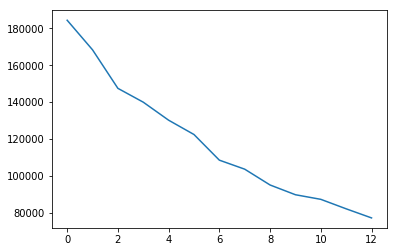

In [67]:
plt.plot(cost)

## Classifier declaration

In [108]:
kmeans = KMeans(n_clusters=8)  
kmeans.fit(scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [109]:
kmeans.labels_

array([0, 1, 5, 0, 2, 2, 3, 5, 5, 5, 5, 7, 2, 1, 5, 5, 1, 2, 0, 0, 1, 3,
       3, 5, 2, 0, 0, 1, 2, 5, 1, 3, 5, 3, 5, 1, 5, 0, 2, 5, 4, 3, 5, 1,
       0, 5, 2, 1, 6, 5, 2, 0, 1, 1], dtype=int32)

In [73]:
mbkmeans = MiniBatchKMeans(n_clusters=6)  
mbkmeans.fit(scaled_df)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=6,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [74]:
mbkmeans.labels_

array([4, 1, 1, 4, 0, 2, 0, 0, 0, 2, 0, 5, 0, 1, 0, 2, 0, 2, 4, 4, 2, 0,
       0, 2, 2, 4, 2, 1, 2, 1, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 3, 0, 2, 1,
       4, 2, 1, 0, 1, 0, 2, 4, 0, 1], dtype=int32)

## Birch + AgglomerativeClustering

In [76]:
birch = Birch(n_clusters=8)
birch.fit(scaled_df)

/home/alexander/.local/lib/python3.6/site-packages/sklearn/cluster/birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node1_dist, node2_dist = dist[[farthest_idx]]


Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=8,
   threshold=0.5)

In [77]:
birch.labels_

array([6, 1, 0, 6, 2, 2, 0, 0, 7, 0, 0, 5, 2, 1, 0, 0, 0, 2, 6, 6, 0, 0,
       0, 0, 2, 6, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 1,
       6, 0, 2, 0, 4, 0, 2, 6, 0, 1])

In [78]:
aggl = AgglomerativeClustering(n_clusters=8)
aggl.fit(scaled_df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=8,
            pooling_func=<function mean at 0x7f116827eae8>)

In [79]:
aggl.labels_

array([6, 1, 0, 6, 2, 2, 0, 0, 7, 0, 0, 5, 2, 1, 0, 0, 0, 2, 6, 6, 0, 0,
       0, 0, 2, 6, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 1,
       6, 0, 2, 0, 4, 0, 2, 6, 0, 1])

# Visualization

In [80]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_df)

### Results for KMeans and MiniBatchKMeans

Clusters are almost similar with slight difference

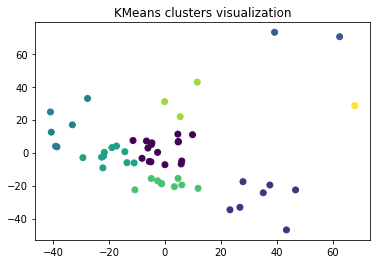

In [97]:
y_pred = KMeans(n_clusters=8).fit_predict(reduced)

plt.scatter(reduced[:, 0], reduced[:, 1], c=y_pred)
plt.title('KMeans clusters visualization')
plt.show()

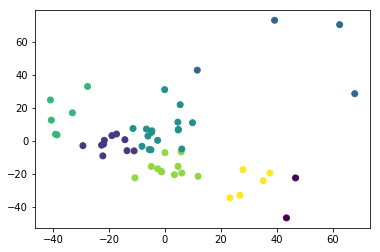

In [83]:
y_pred = MiniBatchKMeans(n_clusters=7).fit_predict(reduced)

plt.scatter(reduced[:, 0], reduced[:, 1], c=y_pred)
plt.show()

### Result for Birch and Agglomerative Clustering
Results are almost the same for these two, but differ from kmeans

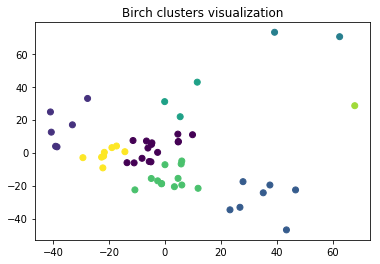

In [84]:
y_pred = Birch(n_clusters=8).fit_predict(reduced)

plt.scatter(reduced[:, 0], reduced[:, 1], c=y_pred)
plt.title('Birch clusters visualization')
plt.show()

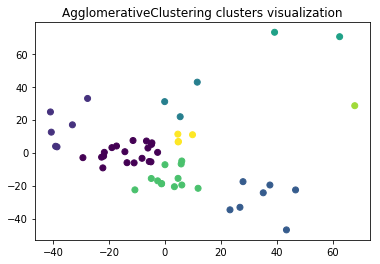

In [85]:
y_pred = AgglomerativeClustering(n_clusters=8).fit_predict(reduced)

plt.scatter(reduced[:, 0], reduced[:, 1], c=y_pred)
plt.title('AgglomerativeClustering clusters visualization')
plt.show()

In [ ]:
result = pd.DataFrame(data=data.values, index=data.index)
result.drop(axis=0, index=['All States and DC (median) **', 'All States, DC and Territories (median) **'], inplace=True)

In [118]:
result['Clusters'] = birch.labels_